In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from skimage.transform import resize
from tensorflow.keras import callbacks
from skimage.io import imread, imshow, imsave

### `DEFAULT PARAMETERS`

In [3]:
Img_width = 128
Img_height = 128
Img_channels = 3
Img_dir = '../../../data/supervisely_person_clean_2667_img'

### `PREPARE DATASET`

In [5]:
Img_cnt = 0
for __, __, files in os.walk(Img_dir + '/images/'):
    Img_cnt = len(files)
    break

In [6]:
x_train = np.zeros((Img_cnt, Img_width, Img_height, Img_channels), dtype=np.float64)
y_train = np.zeros((Img_cnt, Img_width, Img_height, 1), dtype=bool)

In [7]:
# for (root, dirs, files) in os.walk(Img_dir + '/images', topdown=True):
#     for idx, file in tqdm(enumerate(sorted(files))):
#         image = imread(Img_dir + '/images/' + file)
#         image = resize(image, (Img_width, Img_height, 3))
#         image = np.array(image)
#         imsave('data/images/' + file, image)
#         x_train[idx] = image
        
#         mask = imread(Img_dir + '/masks/' + file)
#         mask = resize(mask, (Img_width, Img_height, 1))
#         mask = np.array(mask, dtype=bool)
#         imsave('data/masks/' + file, mask)
#         y_train[idx] = mask

In [8]:
for (root, dirs, files) in os.walk('data/images', topdown=True):
    for idx, file in tqdm(enumerate(sorted(files))):
        image = imread('data/images/' + file)
        x_train[idx] = np.array(resize(image, (Img_width, Img_height, )))
        
        mask = imread('data/masks/' + file)
        mask = np.expand_dims(mask, axis=-1)
        y_train[idx] = np.array(resize(mask, (Img_width, Img_height, )), dtype=bool)

2667it [00:46, 57.02it/s]


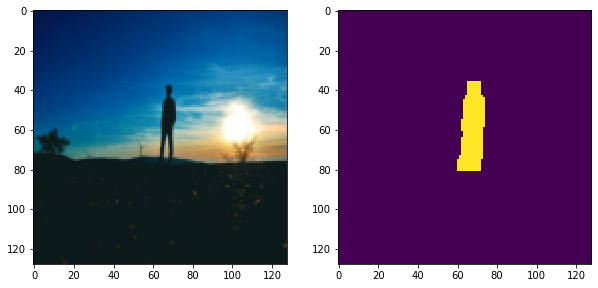

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.imshow(np.squeeze(y_train[0:1]))
ax1.imshow(np.squeeze(x_train[0:1]))
plt.show()

### `LAYERS`

In [4]:
inputs = layers.Input((Img_width, Img_height, Img_channels))
inputs = layers.Lambda(lambda x: x / 255)(inputs)

conv1_1 = layers.Conv2D(112, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv1_2 = layers.Conv2D(112, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1_1)
maxpool_1 = layers.MaxPool2D((2, 2))(conv1_2)

conv2_1 = layers.Conv2D(224, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(maxpool_1)
conv2_2 = layers.Conv2D(224, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2_1)
maxpool_2 = layers.MaxPool2D((2, 2))(conv2_2)

conv3_1 = layers.Conv2D(448, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(maxpool_2)
conv3_2 = layers.Conv2D(448, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3_1)
maxpool_3 = layers.MaxPool2D((2, 2))(conv3_2)

conv4_1 = layers.Conv2D(448, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(maxpool_3)
conv4_2 = layers.Conv2D(448, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4_1)
upconv4 = layers.Conv2DTranspose(448, (2, 2), strides=(2, 2), padding='same')(conv4_2)

upconv4 = layers.concatenate([conv3_2, upconv4])
dropout_5 = layers.Dropout(0.1)(upconv4)
conv5_1 = layers.Conv2D(224, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout_5)
conv5_2 = layers.Conv2D(224, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5_1)
upconv5 = layers.Conv2DTranspose(224, (2, 2), strides=(2, 2), padding='same')(conv5_2)

upconv5 = layers.concatenate([conv2_2, upconv5])
dropout_6 = layers.Dropout(0.1)(upconv5)
conv6_1 = layers.Conv2D(112, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout_6)
conv6_2 = layers.Conv2D(112, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6_1)
upconv6 = layers.Conv2DTranspose(112, (2, 2), strides=(2, 2), padding='same')(conv6_2)

upconv6 = layers.concatenate([conv1_1, upconv6])
dropout_7 = layers.Dropout(0.1)(upconv6)
conv7_1 = layers.Conv2D(112, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dropout_7)
conv7_2 = layers.Conv2D(112, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7_1)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7_2)

(None, 128, 128, 3)


2022-05-17 14:25:36.865277: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 14:25:37.257613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3368 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


In [11]:
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary())

In [12]:
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weigths_only=True,
                monitor='val_accuracy',
                mode='max',
                verbose=1,
                save_best_only=True)

callbacks = [callbacks.EarlyStopping(patience=3, monitor='val_loss')]

In [13]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=16,callbacks=callbacks)

2022-05-12 18:44:27.595123: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 471859200 exceeds 10% of free system memory.
2022-05-12 18:44:28.080890: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 471859200 exceeds 10% of free system memory.


Epoch 1/10


2022-05-12 18:44:31.057330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-12 18:44:31.993782: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-12 18:44:32.621210: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-12 18:44:33.022602: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean 

150/150 [==============================] - 144s 894ms/step - loss: 0.5902 - accuracy: 0.6986 - val_loss: 0.5379 - val_accuracy: 0.7333
Epoch 2/10
150/150 [==============================] - 132s 878ms/step - loss: 0.4993 - accuracy: 0.7621 - val_loss: 0.4484 - val_accuracy: 0.7923
Epoch 3/10
150/150 [==============================] - 132s 879ms/step - loss: 0.4451 - accuracy: 0.8011 - val_loss: 0.4307 - val_accuracy: 0.8096
Epoch 4/10
150/150 [==============================] - 132s 879ms/step - loss: 0.3953 - accuracy: 0.8312 - val_loss: 0.3775 - val_accuracy: 0.8397
Epoch 5/10
150/150 [==============================] - 132s 879ms/step - loss: 0.3481 - accuracy: 0.8523 - val_loss: 0.3283 - val_accuracy: 0.8576
Epoch 6/10
150/150 [==============================] - 132s 880ms/step - loss: 0.3136 - accuracy: 0.8689 - val_loss: 0.3020 - val_accuracy: 0.8699
Epoch 7/10
150/150 [==============================] - 132s 880ms/step - loss: 0.2891 - accuracy: 0.8796 - val_loss: 0.2866 - val_accura

In [54]:
history_dict = history.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
epochs = range(1, len(acc_values) + 1)

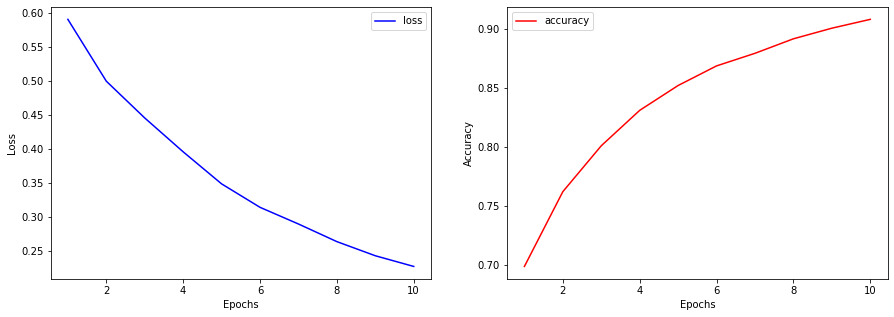

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epochs, loss_values, 'b', label='loss')
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.legend()

ax2.plot(epochs, acc_values, 'r', label='accuracy')
ax2.set(xlabel='Epochs', ylabel='Accuracy')
ax2.legend()

plt.show()

In [16]:
model.save('tmp/model1')

INFO:tensorflow:Assets written to: tmp/model1/assets


In [15]:
history_ = model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=16,callbacks=callbacks)

2022-05-12 19:13:57.151032: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 471859200 exceeds 10% of free system memory.
2022-05-12 19:13:57.847590: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 471859200 exceeds 10% of free system memory.


Epoch 1/10
150/150 [==============================] - 158s 1s/step - loss: 0.2079 - accuracy: 0.9165 - val_loss: 0.2851 - val_accuracy: 0.8890
Epoch 2/10
150/150 [==============================] - 159s 1s/step - loss: 0.1848 - accuracy: 0.9265 - val_loss: 0.2335 - val_accuracy: 0.9031
Epoch 3/10
150/150 [==============================] - 159s 1s/step - loss: 0.1687 - accuracy: 0.9333 - val_loss: 0.2273 - val_accuracy: 0.9034
Epoch 4/10
150/150 [==============================] - 159s 1s/step - loss: 0.1453 - accuracy: 0.9428 - val_loss: 0.2275 - val_accuracy: 0.9120
Epoch 5/10
150/150 [==============================] - 159s 1s/step - loss: 0.1301 - accuracy: 0.9491 - val_loss: 0.2324 - val_accuracy: 0.9128
Epoch 6/10
150/150 [==============================] - 159s 1s/step - loss: 0.1236 - accuracy: 0.9525 - val_loss: 0.2495 - val_accuracy: 0.9062


In [56]:
history_dict = history_.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
epochs = range(1, len(acc_values) + 1)

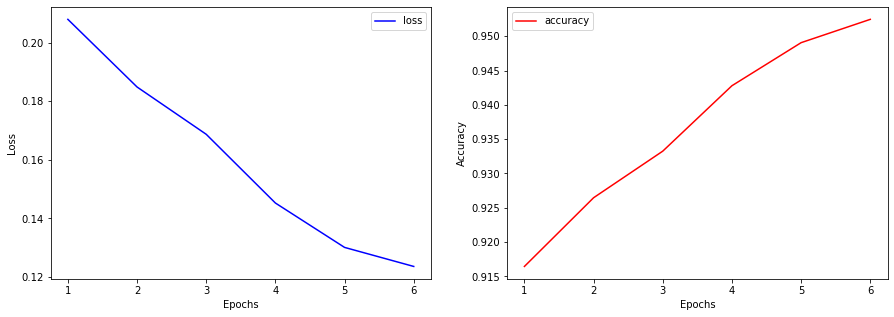

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epochs, loss_values, 'b', label='loss')
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.legend()

ax2.plot(epochs, acc_values, 'r', label='accuracy')
ax2.set(xlabel='Epochs', ylabel='Accuracy')
ax2.legend()

plt.show()

In [17]:
history__ = model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=16,callbacks=callbacks)

2022-05-12 19:32:36.960836: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 471859200 exceeds 10% of free system memory.


Epoch 1/10
150/150 [==============================] - 132s 877ms/step - loss: 0.1019 - accuracy: 0.9605 - val_loss: 0.2629 - val_accuracy: 0.9067
Epoch 2/10
150/150 [==============================] - 132s 879ms/step - loss: 0.0820 - accuracy: 0.9685 - val_loss: 0.2661 - val_accuracy: 0.9126
Epoch 3/10
150/150 [==============================] - 132s 880ms/step - loss: 0.0726 - accuracy: 0.9723 - val_loss: 0.3145 - val_accuracy: 0.9053
Epoch 4/10
150/150 [==============================] - 132s 881ms/step - loss: 0.0725 - accuracy: 0.9725 - val_loss: 0.2965 - val_accuracy: 0.9064


In [58]:
history_dict = history_.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
epochs = range(1, len(acc_values) + 1)

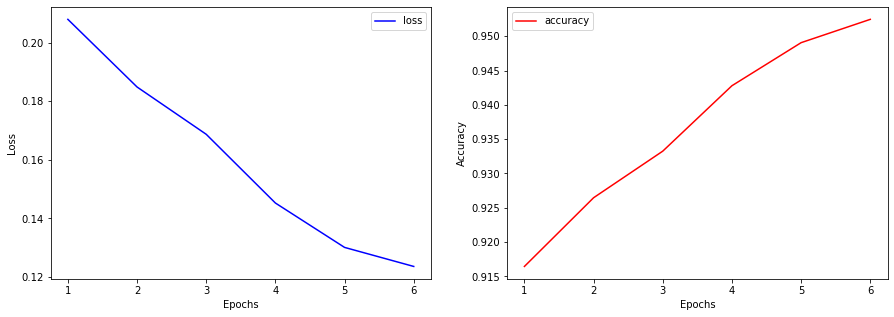

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epochs, loss_values, 'b', label='loss')
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.legend()

ax2.plot(epochs, acc_values, 'r', label='accuracy')
ax2.set(xlabel='Epochs', ylabel='Accuracy')
ax2.legend()

plt.show()

In [24]:
x_test = np.zeros((Img_cnt, Img_width, Img_height, Img_channels), dtype=np.float64)

In [46]:
predicted_mask = np.zeros((Img_cnt, Img_width, Img_height, 1), dtype=bool)

In [49]:
for (root, dirs, files) in os.walk('test', topdown=True):
    for idx, file in tqdm(enumerate(sorted(files))):
        image = imread('test/' + file)
        image = resize(image, (Img_width, Img_height, 3))
        image = np.array(image)
        x_test[idx] = image

3it [00:00,  4.39it/s]


In [50]:
predicted_mask = model.predict(x_test)

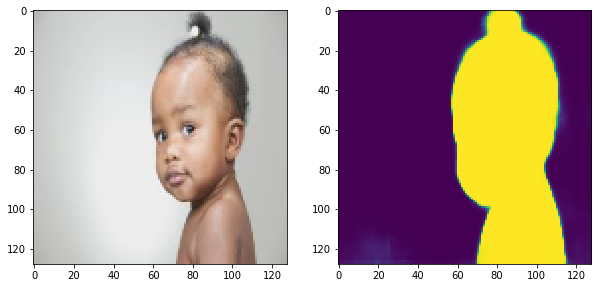

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(np.squeeze(x_test[1]))
ax2.imshow(np.squeeze(predicted_mask[1]))
plt.show()